In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader, IterableDataset

from torchvision.datasets import MNIST,CIFAR10
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

from lib.server import Server
from lib.client import Client
from lib.data_helper import *
from lib.train_helper import *
from lib.plots import plot_loss_epoch

## Data

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [3]:
dataset = MNIST('data', train=True, download=True, transform=transforms.ToTensor())
dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
train_dataset, valid_dataset = random_split(dataset, [int(len(dataset) * 0.83), int(len(dataset) * 0.17)])

## Network

In [5]:
def toy_net():
    return nn.Sequential(
        nn.Conv2d(1, 20, 7),
        nn.ReLU(),
        nn.Conv2d(20, 40, 7),
        nn.ReLU(),
        nn.MaxPool2d(2, 2),
        nn.Flatten(),
        nn.Linear(2560, 10)
    )
toy_net()

Sequential(
  (0): Conv2d(1, 20, kernel_size=(7, 7), stride=(1, 1))
  (1): ReLU()
  (2): Conv2d(20, 40, kernel_size=(7, 7), stride=(1, 1))
  (3): ReLU()
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=2560, out_features=10, bias=True)
)

## Server-Clients configuration

In [6]:
# underlying module must be of the same class in server & clients
server = Server(toy_net().to(device))
N = 8 # number of clients
partition = partition_by_class(train_dataset)

# for even (iid) split -> set alpha to very big value like 10e8 or very small like 10e-8
# here alpha=0.1 creates very uneven (non-iid) splits
clients = [Client(i,d,toy_net().to(device)) for i,d in enumerate(split(partition,N,alpha=0.1),start=1)]

In [7]:
def run(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optimizer,lr,**kwargs):
    train_loader = DeviceDataLoader(DataLoader(train_dataset, batch_size, shuffle=True), device)
    valid_loader = DeviceDataLoader(DataLoader(valid_dataset, batch_size, shuffle=True), device)
    history = []
    for i in range(rounds):
        print(f'Start Round {i+1} ...')
        server_params = server.net.state_dict()
        clients_params = []
        for client in clients:
                    #train(device, state_dict, epochs, batch_size, opt, lr, **kwargs)
            client.train(device,server_params,epochs,batch_size, optimizer,lr,**kwargs)
        server.merge(clients)
        
        train_loss, train_acc = evaluate(server.net,train_loader)
        dev_loss, dev_acc = evaluate(server.net,valid_loader)
        
        print(f'''After round {i+1} :
        - training loss = {train_loss:.4f}
        - training accuracy = {train_acc:.4f}
        - validation loss = {dev_loss:.4f}
        - validation accuracy = {dev_acc:.4f}
        ''')
        
        history.append((train_loss, dev_loss))
    return history

## SGD

In [8]:
rounds = 10
batch_size = 128
epochs = 3
lr = 1e-3

Start Round 1 ...
1: Loss = 0.6269, Accuracy = 0.8122
2: Loss = 0.8862, Accuracy = 0.7017
3: Loss = 1.2431, Accuracy = 0.6113
4: Loss = 1.4545, Accuracy = 0.6280
5: Loss = 0.8172, Accuracy = 0.7263
6: Loss = 0.2466, Accuracy = 0.9792
7: Loss = 1.5532, Accuracy = 0.5564
8: Loss = 2.0122, Accuracy = 0.5508
After round 1 :
        - training loss = 2.2161
        - training accuracy = 0.2094
        - validation loss = 2.2141
        - validation accuracy = 0.2133
        
Start Round 2 ...
1: Loss = 0.4050, Accuracy = 0.9358
2: Loss = 0.6097, Accuracy = 0.8101
3: Loss = 0.9265, Accuracy = 0.6989
4: Loss = 0.9049, Accuracy = 0.7616
5: Loss = 0.5613, Accuracy = 0.8914
6: Loss = 0.1634, Accuracy = 0.9792
7: Loss = 0.9650, Accuracy = 0.7462
8: Loss = 1.3009, Accuracy = 0.8187
After round 2 :
        - training loss = 1.9832
        - training accuracy = 0.3215
        - validation loss = 1.9813
        - validation accuracy = 0.3232
        
Start Round 3 ...
1: Loss = 0.2547, Accuracy = 0.9

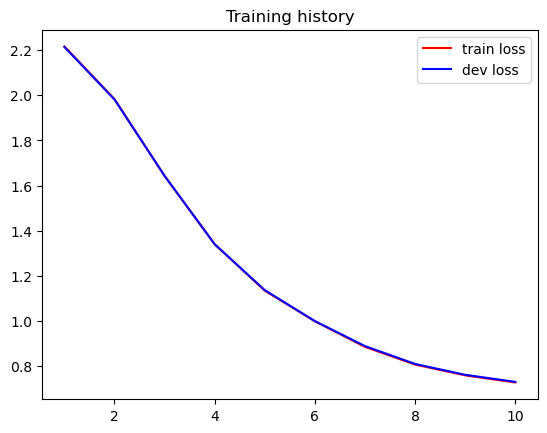

In [9]:
history = run(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optim.SGD,lr)
plot_loss_epoch(history)

## Adagrad

In [10]:
rounds = 10
batch_size = 128
epochs = 3
lr = 1e-3

Start Round 1 ...
1: Loss = 0.0592, Accuracy = 0.9829
2: Loss = 0.1219, Accuracy = 0.9566
3: Loss = 0.1600, Accuracy = 0.9472
4: Loss = 0.2190, Accuracy = 0.9340
5: Loss = 0.0812, Accuracy = 0.9766
6: Loss = 0.0347, Accuracy = 0.9915
7: Loss = 0.1693, Accuracy = 0.9529
8: Loss = 0.2285, Accuracy = 0.9243
After round 1 :
        - training loss = 0.6506
        - training accuracy = 0.7746
        - validation loss = 0.6556
        - validation accuracy = 0.7734
        
Start Round 2 ...
1: Loss = 0.0450, Accuracy = 0.9875
2: Loss = 0.0939, Accuracy = 0.9706
3: Loss = 0.1282, Accuracy = 0.9608
4: Loss = 0.1694, Accuracy = 0.9499
5: Loss = 0.0612, Accuracy = 0.9828
6: Loss = 0.0226, Accuracy = 0.9935
7: Loss = 0.1270, Accuracy = 0.9624
8: Loss = 0.1614, Accuracy = 0.9431
After round 2 :
        - training loss = 0.4729
        - training accuracy = 0.8422
        - validation loss = 0.4763
        - validation accuracy = 0.8419
        
Start Round 3 ...
1: Loss = 0.0342, Accuracy = 0.9

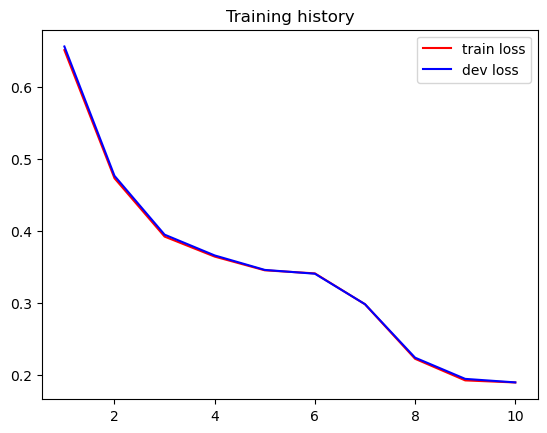

In [11]:
history = run(server,clients,device,train_dataset,valid_dataset,rounds,epochs,batch_size,optim.Adagrad,lr)
plot_loss_epoch(history)